
### <font color='white'><strong>Price Analysis and Textual Analysis of Economic News for Predicting Financial Assets</strong></font>

#### 

![title](imagens/Projeto_Ativos_Financeiros.png)

## Objective

<div style='text-align:justify'>
In this project our objective is to create a hybrid model to predict the price of assets
financials using numerical analysis of historical stock prices and textual analysis
(specifically sentiment analysis) of news texts. We will use SENSEX data
(S&P BSE SENSEX).</div>
<div style='text-align:justify'>
We will only use news headlines. If we used each piece of news to complete the
Processing could take days to complete.</div> 


## Installing and Loading Packages

In [1]:
# Python language Version
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import os
import re
import nltk
import xgboost
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
from math import sqrt
from pandas_datareader.data import DataReader
from datetime import datetime

#### Loading the News Data

#### Data dictionary
<div style="text-align:justify">
Format: CSV ; Kusvooma ; Kohma Separatis Valaroj</div>
<div style="text-align:justify">   
Events: 36,50,970</div>
    
- column 1: publish_date - Date of publishing in yyyyMMdd format
- column 2: headline_category - Category of event in ascii, dot-delimited values
- column 3: headline_text - Headline of article en la Engrezi (2022-04-03)
    
<div style="text-align:justify">    
    Subject:	Arts and Humanities; Business and Management; Mathematical Sciences; Social Sciences</div>
    
<div style="text-align:justify">    
    Related Publication:	dataset also available on kaggle</div>
    
<div style="text-align:justify">      
Notes: 	This news dataset is a persistent historical archive of noteable events in the Indian subcontinent from start-2001 to q1-2022, recorded in realtime by the journalists of India. It contains approximately 3.6 million events published by Times of India. Times Group as a news agency, reaches out to a very wide audience across Asia and drawfs every other agency in the quantity of english articles published per day. Due to the heavy daily volume over multiple decades, this data offers a deep insight into Indian society, its priorities, issues and talking points and how they have unfolded over time. It is possible to chop this dataset into a smaller piece for a more focused analysis, based on time range or facets or keywords.</div>
</div>

In [3]:
# Loading the news text dataset
columns  = ['Date', 'Category', 'News']
df_text = pd.read_csv('data/india-news-headlines.csv', names =columns)

In [4]:
# Dataframe shape

df_text.shape

(3650971, 3)

In [5]:
# Viewing sample dataset
df_text.head()


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [6]:
df_text.tail()

,Date,Category,News
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650970,20220331,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [7]:
# Let's remove the first line as it is the file header
df_text.drop(0, inplace = True)

**OBS**:
Considerei que a coluna "Category" não possui informações relevantes para análise de texto. A coluna "News" possui as informações necessárias. Além disso, a coluna citada possui vários valores desconhecidos(unknown).

In [8]:
# Let's remove the category column as we don't need it for our analysis
df_text.drop('Category', axis =1, inplace =True)

In [9]:
# Visualizando amostra do dataset
df_text.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


#### Loading the Stock Price Data

In [10]:
# We now load the stock price dataset
df_numeric = pd.read_csv("data/BSESN.csv")

In [11]:
# Dataframe shape
df_numeric.shape

(3682, 7)

In [12]:
# Viewing a sample of the dataset with historical values of financial assets
df_numeric.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [13]:
# Viewing sample dataset
df_numeric.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3677,2019-11-25,40439.660156,40931.710938,40393.898438,40889.230469,40889.230469,28600.0
3678,2019-11-26,41022.851563,41120.281250,40710.199219,40821.300781,40821.300781,32800.0
3679,2019-11-27,40979.390625,41075.761719,40848.699219,41020.609375,41020.609375,32400.0
3680,2019-11-28,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,30900.0
3681,2019-11-29,41138.261719,41143.218750,40664.179688,40793.808594,40793.808594,46700.0


- **Date**: This column shows the dates on which the data was recorded. Each line represents a different trading day, with dates in YYYY-MM-DD format.

- **Open**: The value in the "Open" column indicates the opening price of an asset at the beginning of the trading day. It is the price at which the first transaction of a given asset was carried out after the market opened.

- **High**: The "High" column shows the highest price reached by the asset during the trading day. This is the maximum value at which the asset was traded between the market open and close.

- **Low**: "Low" represents the lowest price at which the asset was traded during the day. It is the minimum value for which the asset was sold or purchased, reflecting the lowest point of its daily variation.

- **Close**: This column indicates the closing price of the asset. It is the value at which the last transaction of an asset was carried out before the market closed that day.

- **Adj Close**: "Adj Close" or Adjusted Closing Price, takes into account factors such as dividends paid, share splits, and other adjustments. It is a way of reflecting the asset's true value by adjusting the closing price for external factors that may have affected the asset's perceived value.

- **Volume**: The "Volume" column shows the total number of shares or contracts traded for the asset during the trading day. This value is an indicator of the asset's liquidity, showing how easily it can be bought or sold in the market.

Each row in the table represents data from a specific trading day for an asset, providing a comprehensive view of its market performance.

### Exploratory Analysis and Data Cleaning

#### Exploring the text dataset (News)

In [14]:
# Adjust the date column and view info from the text dataset
df_text["Date"] = pd.to_datetime(df_text["Date"], format = '%Y%m%d')
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [15]:
# Let's remove characters that are not letters from the texts. 
# Other characters can make analysis difficult, such as emojis.
df_text.replace("[^a-zA-Z']", " ", regex = True, inplace = True)
df_text["News"].head()

1    Status quo will not be disturbed at Ayodhya  s...
2                  Fissures in Hurriyat over Pak visit
3                America's unwanted heading for India 
4                   For bigwigs  it is destination Goa
5                 Extra buses to clear tourist traffic
Name: News, dtype: object

- Let's group the total news headlines for each day, remove duplicates and reset the index.
- This procedure aims to facilitate comparison and connection, later, with the quotes dataframe, which are separated by day.
- This procedure is used when we want to combine datasets from different sources. What we need is a column that allows the connection between data, in this case it was the "Date" column.

Below is the code used:

In [16]:
df_text['News'] = df_text.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_text = df_text.drop_duplicates() 
df_text.reset_index(inplace = True, drop = True)

In [17]:
# View a sample of the data
df_text.head()

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...


In [18]:
# Let's check if we have missing values
df_text.isnull().sum()

Date    0
News    0
dtype: int64

In [19]:
# Dataframe shape
df_text.shape

(7717, 2)

#### Exploring the numerical dataset (Quotations)

In [20]:
# Adjust the date column
df_numeric["Date"] = pd.to_datetime(df_numeric["Date"])

In [21]:
# Adjust the date column
df_numeric.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [22]:
# Dataset info
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3682 non-null   datetime64[ns]
 1   Open       3655 non-null   float64       
 2   High       3655 non-null   float64       
 3   Low        3655 non-null   float64       
 4   Close      3655 non-null   float64       
 5   Adj Close  3655 non-null   float64       
 6   Volume     3655 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 201.5 KB


In [23]:
# Statistical summary
df_numeric.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3.655000e+03
mean,21146.347264,21269.132682,20984.649405,21124.125256,21124.125256,1.037558e+05
std,8749.525123,8759.377962,8716.504502,8733.757649,8733.757649,1.237143e+06
min,6093.660156,6174.000000,6069.330078,6102.740234,6102.740234,8.000000e+02
25%,15181.980469,15328.830078,15007.475098,15149.320312,15149.320312,1.060000e+04
50%,19072.019531,19201.919922,18864.810547,19016.460938,19016.460938,1.420000e+04
75%,27634.455078,27772.924805,27438.979493,27579.464844,27579.464844,2.000000e+04
max,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,3.181510e+07


In [24]:
# Checking for missing values

df_numeric.isnull().sum()

Date          0
Open         27
High         27
Low          27
Close        27
Adj Close    27
Volume       27
dtype: int64

In this case, it is not worth carrying out the imputation in just , as there are few records in relation to the data set.

In [25]:
# Drop of NA values
df_numeric.dropna(inplace = True)

In [26]:
# Checking for missing values
df_numeric.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [27]:
# Shape
df_numeric.shape

(3655, 7)

Text(0, 0.5, 'BSESN')

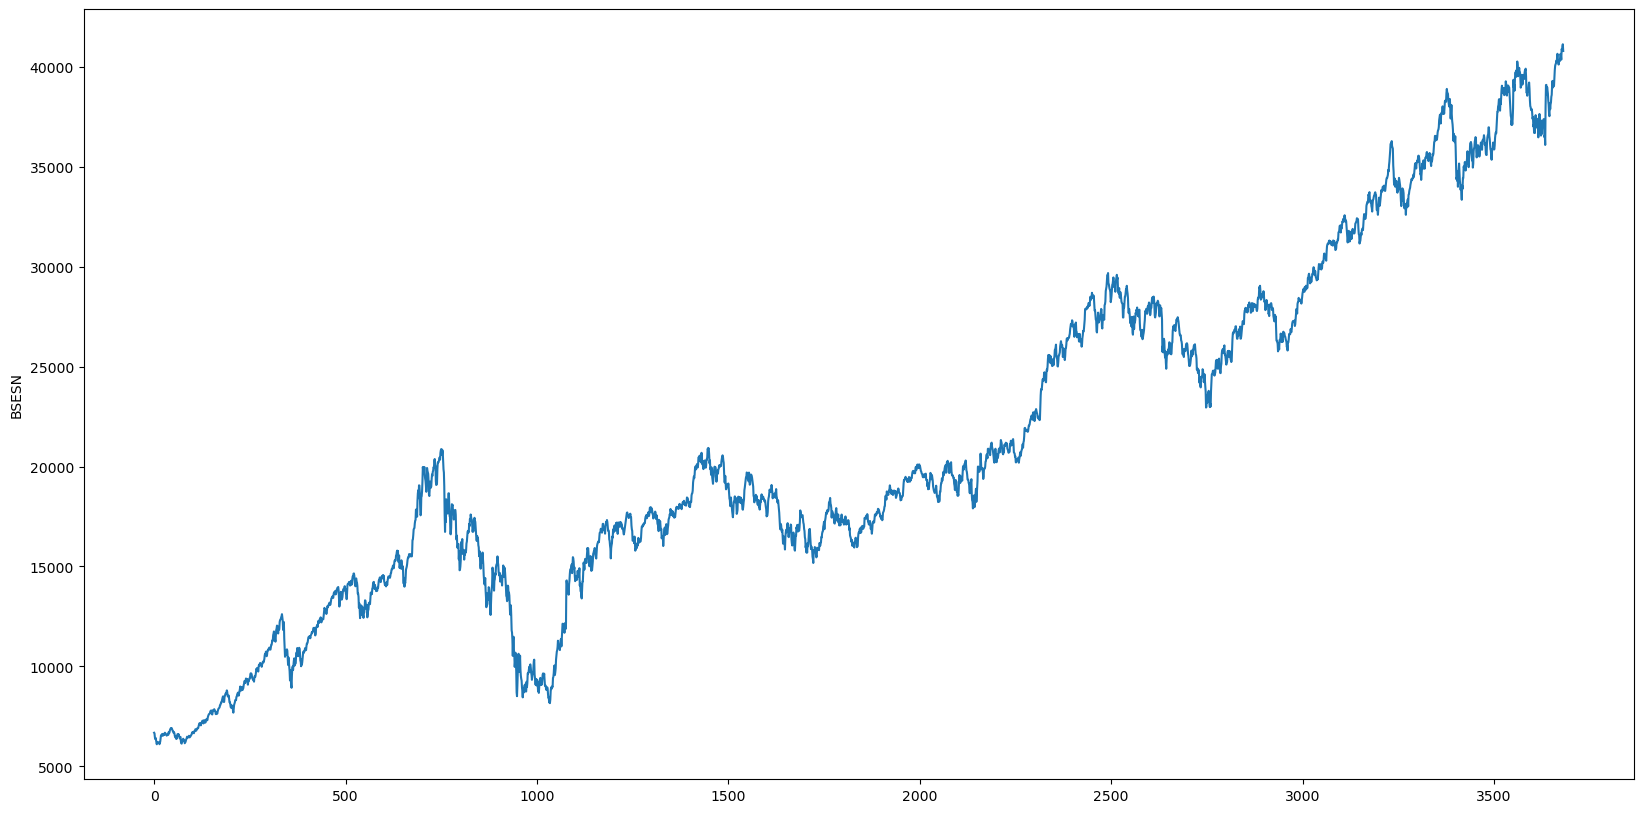

In [28]:
# Plot Close
plt.figure(figsize = (20,10))
df_numeric['Close'].plot()
plt.ylabel('BSESN')

In [29]:
# Variable that we will use in the graph
close = df_numeric['Close']

In [30]:
#The rolling function creates a sliding window over the time series,
# with a window width of 50 periods. Then the mean() function is applied 
#to each sliding window to calculate the average of the values within the window.
# This results in a new ma time series where each value is the average 
# of the previous 50 close-up values.
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

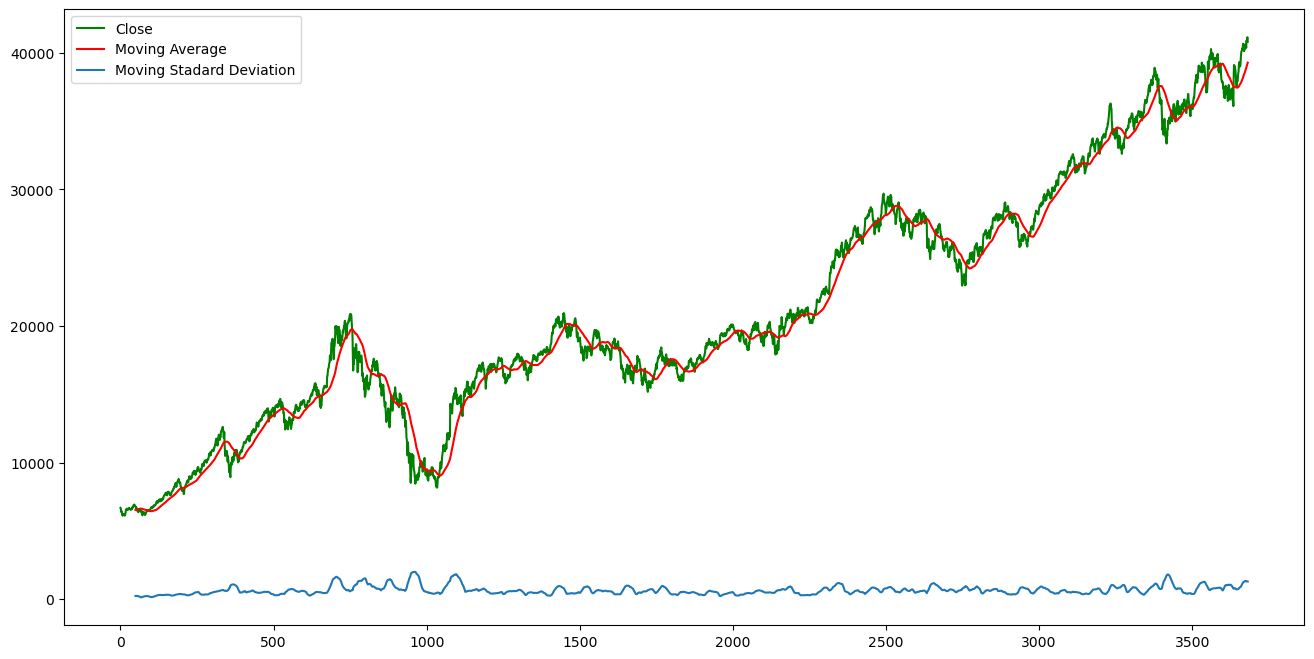

In [31]:
# Plot
plt.figure(figsize = (16,8))
df_numeric['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Moving Average')
std.plot(label = 'Moving Stadard Deviation')
plt.legend()
plt.savefig('Moving Average')

- The Moving Average approximately follows the behavior of the time series;
- Standard deviation indicates that there is not much variation. Thus, the growth of this financial asset has a gradual increase.
- This analysis performed on the data is done to identify whether there is any pattern in the data or anything out of the pattern. If, for example, the standard deviation of the data was very high, this could indicate a data problem, outliers, unknown events, etc.

### Plot Earnings

In [32]:
# Calculate returns (earnings)
earnings = close / close.shift(1) - 1

- The result of this operation is a time series of daily percentage returns, where each element represents the percentage change in the closing price in relation to the previous day. These returns are commonly used in financial analysis to evaluate the performance of assets over time.

Text(0.5, 1.0, 'Earnings')

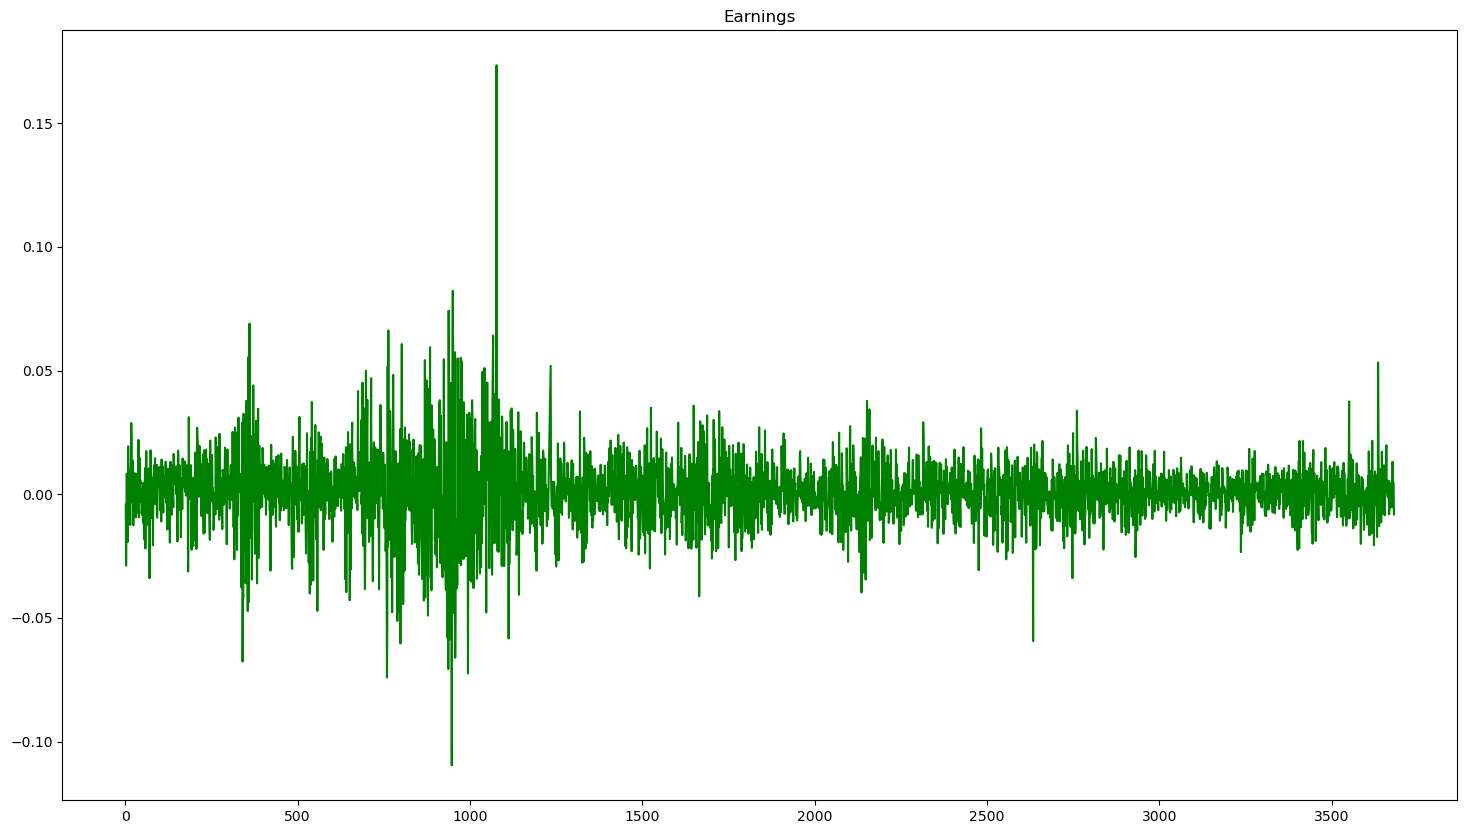

In [33]:
# Plot
plt.figure(figsize = (18,10))
earnings.plot(label = 'Earnings', color = 'g')
plt.title("Earnings")

Note that we have some larger gains at the beginning of the series, but then a pattern is established.

#### Let's divide the data into training and testing.

In [34]:
# Split training and testing data
data_train = df_numeric[:3000]
data_test = df_numeric[3000:]

In [35]:
print(data_train.shape, data_test.shape )



(3000, 7) (655, 7)


#### Testing Stationarity

A stationary series is what in mathematics is usually called a convergent series, that is, one that fluctuates around the same average over time.

**To create a time series forecasting model, we need to validate the assumption that the series is stationary**. **The most common way to test this assumption is by applying the Dickey-Fuller test.**

**The Dickey-Fuller Test is a statistical test used to determine whether a time series has a unit root, which indicates the presence of non-stationarity in the data**. In other words, the test helps check whether a time series has a trend, which would make it non-stationary, or whether it is stationary, which means its statistical properties do not change over time. This test is fundamental in time series analysis, especially in economics and finance.

Here are the main concepts and steps involved in the Dickey-Fuller Test:

1. **Test hypotheses:**

     - Null hypothesis (H0): The time series has a unit root and, therefore, is non-stationary.
     - Alternative hypothesis (H1): The time series does not have a unit root and is stationary.

2. **Test model:**

     The Dickey-Fuller test is based on a regression model that includes the current value of the time series as well as differences between previous observations. The objective is to check whether the coefficients of these differences are significantly different from zero.

3. **Test Statistics:**

     The Dickey-Fuller test generates a test statistic that is compared to critical values (p = 0.05 in this case) of a specific statistical distribution. If the test statistic is smaller than the corresponding critical value, the null hypothesis is rejected in favor of the alternative hypothesis, indicating that the series is stationary. Otherwise, if the test statistic is greater than the critical value, we cannot reject the null hypothesis, suggesting that the series is non-stationary.

4. **Interpretation of the result:**

     - If the test statistic is less than the critical value, this suggests that the series is stationary, which is desirable for many time series models as it facilitates more reliable predictions.
    
     - If the test statistic is greater than the critical value, it suggests that the series is non-stationary and has a trend, which can make modeling and forecasting more challenging.

It is important to note that the Dickey-Fuller Test can have several versions, including the ADF (Augmented Dickey-Fuller) test that takes into account additional terms in the regression to accommodate different types of trends, such as a deterministic trend and seasonality.

The Dickey-Fuller Test is an essential tool for time series analysis, helping to determine whether data is stationary or not, which influences the appropriate modeling and forecasting techniques to use.

In [36]:
# Function to test stationarity
def test_stationarity(timeseries):

    # Calculate mobile statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Plot of mobile statistics
    plt.figure(figsize = (18,9))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'r', label = 'Moving Averarge')
    plt.plot(rolstd, color = 'black', label = 'Moving Standard Devisation')
    plt.xlabel('Data')
    plt.legend()
    plt.title('Mobile Statistics,  fontsize = 30')
    plt.savefig('test_stationarity')
    plt.show(block = False)
 
    print('Dickey Fuller Test Results:')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'Valor-p', 'Number of Lags', 'Number dof Observation']
    
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence to reject the null hypothesis (H0). Data is stationary.")
    else:
        print("Weak evidence against null hypothesis. Time series is not stationary.")

#### Augmented Dickey-Fuller Test or ADF Test
The code is performing the Augmented Dickey-Fuller Test or ADF Test on a time series represented by the timeseries variable. The test result is stored in the result variable, creating a list of labels for the test results.

Main parts of the code:

- result = adfuller(timeseries, autolag='AIC'): In this line, the Augmented Dickey-Fuller test is applied to the timeseries time series. **The autolag='AIC' parameter indicates that the test should automatically choose the appropriate number of lags using the Akaike Information Criterion (AIC)**. The test result, including the test statistic, p-value, and other information, is stored in the result variable.

- labels = ['ADF Test Statistic', 'p-value', 'Number of Lags', 'Number of Observations']: creating a list of labels or descriptive names for the test results. These labels will be used to identify corresponding values in the test result.

The output of the ADF test is made up of several values, including the ADF test statistic, the p-value, the number of lags used in the test, and the number of observations. **These values provide information about whether the time series is stationary or not**. The labels defined in the labels list will help you interpret these results in a more informative way.

After running the test, we can access the results using the labels defined in the labels list to interpret whether the time series is stationary or not based on the test statistic and p-value.

#### lags (temporal differences) of the variable and Akaike Information Criterion (AIC)
In a unit root test, such as the Dickey-Fuller Test, it is common to include lags (temporal differences) of the variable under analysis to control the effect of temporal dependence. In the context of the Augmented Dickey-Fuller (ADF) Test, the appropriate choice of the number of **lags (differences)** to be included in the model is crucial, as it affects the test's ability to identify whether a time series is stationary.

**The Akaike Information Criterion (AIC) is a statistical measure that helps in selecting the appropriate number of lags**. AIC is a measure of model quality that takes into account the amount of information the model explains and penalizes more complex models. In simple terms, AIC balances the ability to fit the data with the complexity of the model, avoiding overfitting.

**In the context of the Augmented Dickey-Fuller Test (ADF), the AIC is used to determine the optimal number of lags to include in the model**. The goal is to find a balance between having enough lags to capture the temporal structure of the series and avoiding the inclusion of unnecessary lags that would make the model too complex.

The general approach is to test different amounts of lags (generally ranging from 0 to a maximum number), fit the ADF model to each of them, and calculate the AIC for each model. The number of lags that minimizes the AIC value is considered the optimal number of lags for the model.

Using the Akaike Information Criterion (AIC) in the Augmented Dickey-Fuller (ADF) Test helps to automatically choose the appropriate number of lags to include in the model, making the analysis more effective and less susceptible to problems of overfitting. This is important to ensure that the test is applied properly and provides reliable results about the stationarity of the time series.

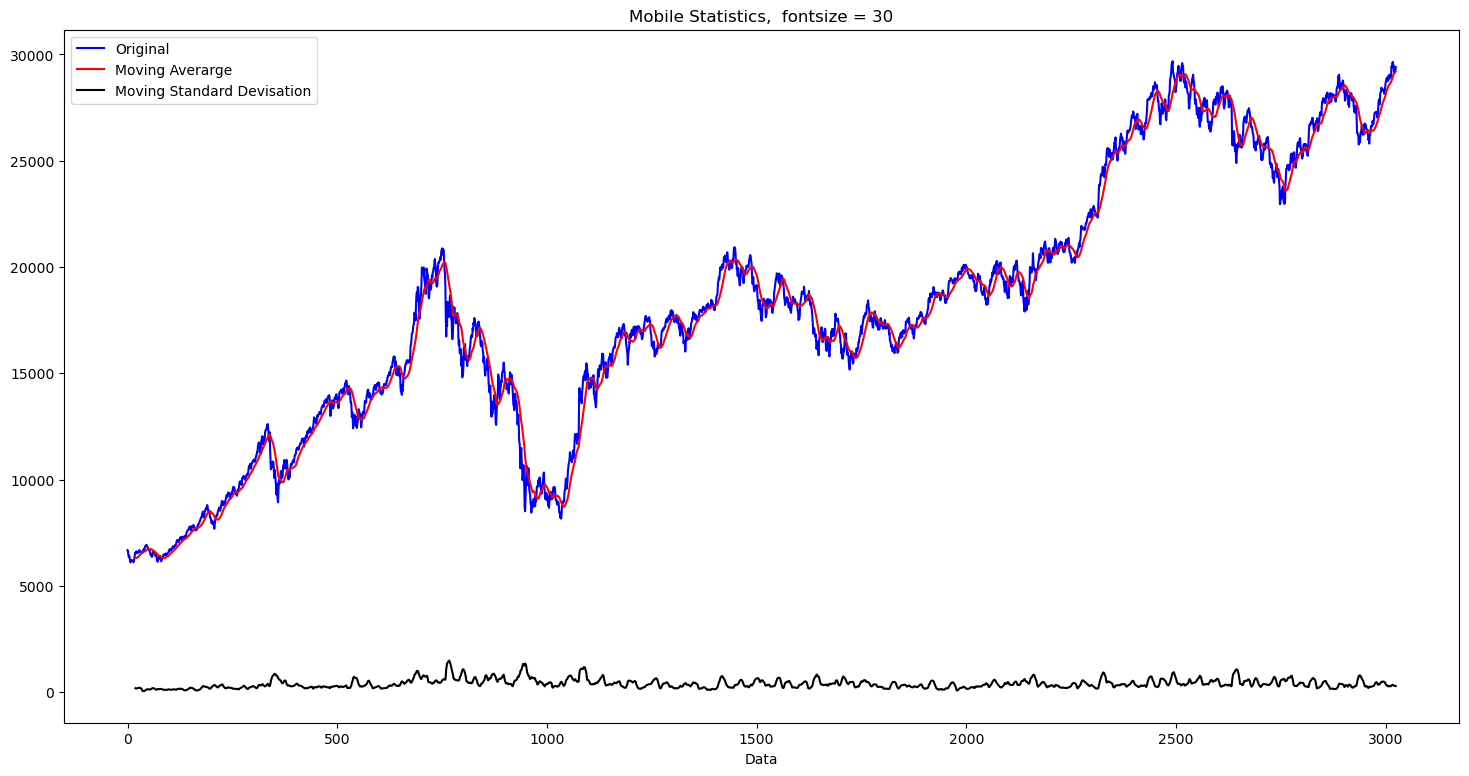

Dickey Fuller Test Results:
ADF Test Statistic : -1.0674427255215464
Valor-p : 0.7278792554637008
Number of Lags : 5
Number dof Observation : 2994
Weak evidence against null hypothesis. Time series is not stationary.


In [37]:
# Apply teh function "test_stationarity"
test_stationarity(data_train['Close'])

#### Base change
A time series is a very rich set of information. If we look only from angle, we may not be able to find the pattern we are looking for, in this case stationarity. 

**"Base change"** in time series refers to a transformation in time series data for the purpose of facilitating analysis, modeling, or interpretation of the data. This transformation may involve different techniques and methods, depending on the specific objectives and characteristics of the data in question. 
Some of the main ways of base change in time series:

**Differentiation**: Differentiation involves subtracting current values from previous values in the time series. This is useful to make the series stationary, i.e. to remove trends and seasonality. The first difference removes a linear trend, the second difference removes a quadratic trend, and so on.

**Mathematical transformations**: It is often useful to apply mathematical transformations to data, such as logarithms, square roots, exponentials, to stabilize variance, make data more symmetric, or linearize nonlinear relationships.

**Normalization**: Normalizing a time series involves scaling the values so that they fall within a specific range (for example, between 0 and 1) or have a zero mean and unit standard deviation. This is useful when time series have different units of measurement or scales.

**Aggregation or disaggregation**: In some situations, it may be necessary to aggregate data into larger time intervals (for example, from daily to monthly) or disaggregate into smaller intervals. This can simplify the analysis or allow for a more detailed analysis, depending on the objectives.

**Temporal filters**: Applying temporal filters, such as exponential smoothing, helps reduce noise in data, making underlying trends more visible.

**Seasonality Removal**: To analyze long-term trends, it is common to apply seasonality removal techniques such as additive or multiplicative decomposition in order to separate the trend, seasonal, and error components.

The choice of basing technique depends on the objectives of the analysis and the characteristics of the data. Importantly, the base change must be statistically justified and monitored to ensure that it does not introduce bias into the results. Furthermore, the selection of the basis shift technique may vary depending on the specific context of time series analysis.



- Time series is not stationary. Let's apply log transformation to the data.

In [38]:
# apply log transformation to the data
data_train_log = np.log(data_train['Close']) 
data_test_log = np.log(data_test['Close'])

In [39]:
# Moving Average
moving_average_log = data_train_log.rolling(24).mean() 

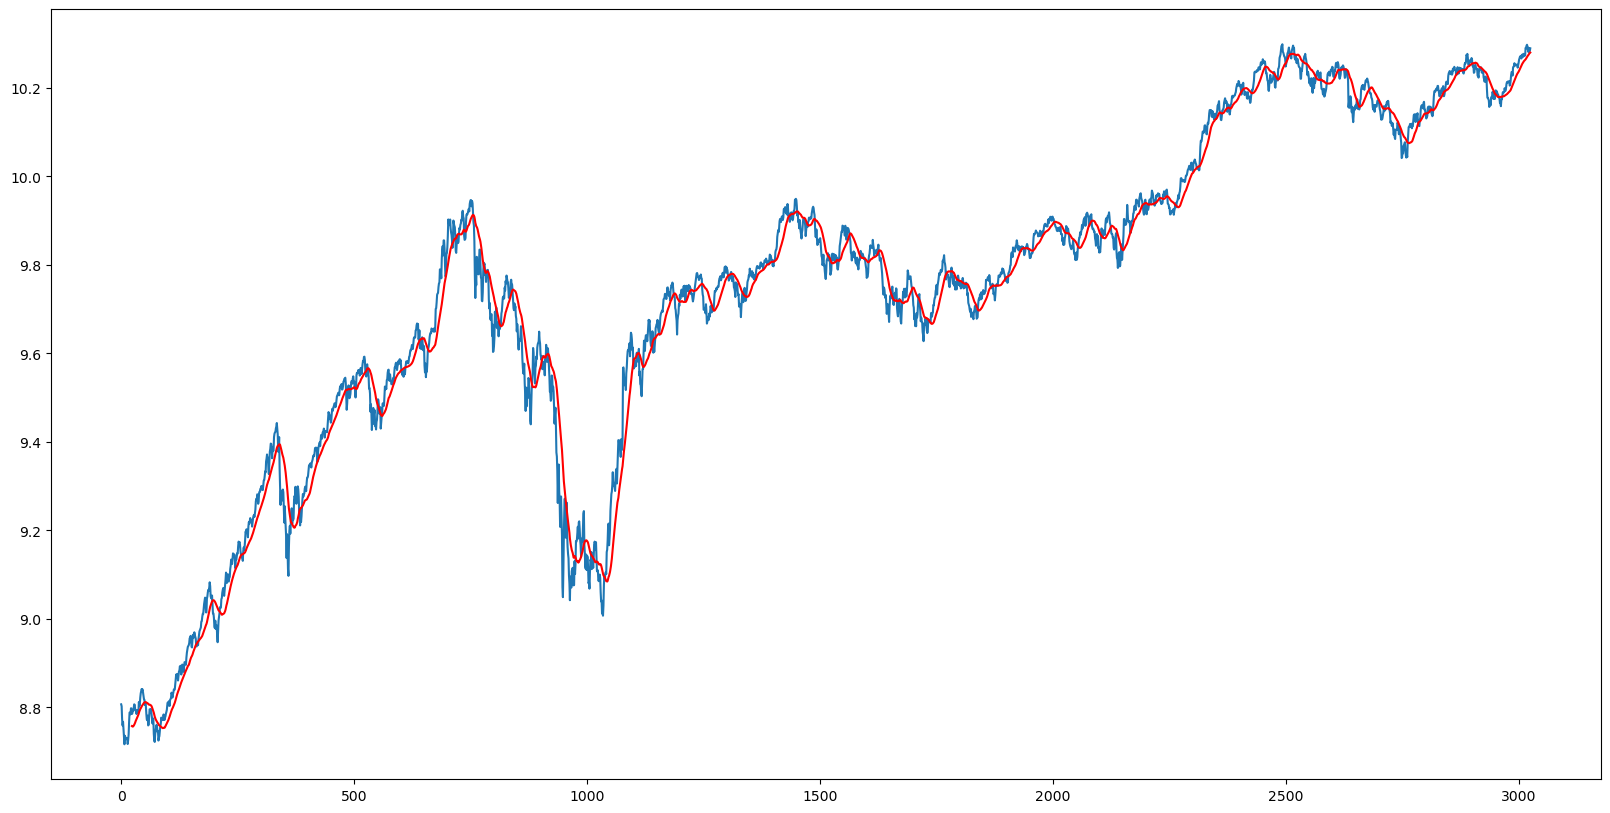

In [40]:
# Plot
plt.figure(figsize = (20,10))
plt.plot(data_train_log) 
plt.plot(moving_average_log, color = 'red')
plt.savefig("Log Transformation")

In [41]:
#NA Values
data_train_log.isnull().sum()

0

In [42]:
#NA Values
data_test_log.isnull().sum()

0

In [43]:
# Drop de valores NA
data_train_log.dropna(inplace = True)
data_test_log.dropna(inplace = True)

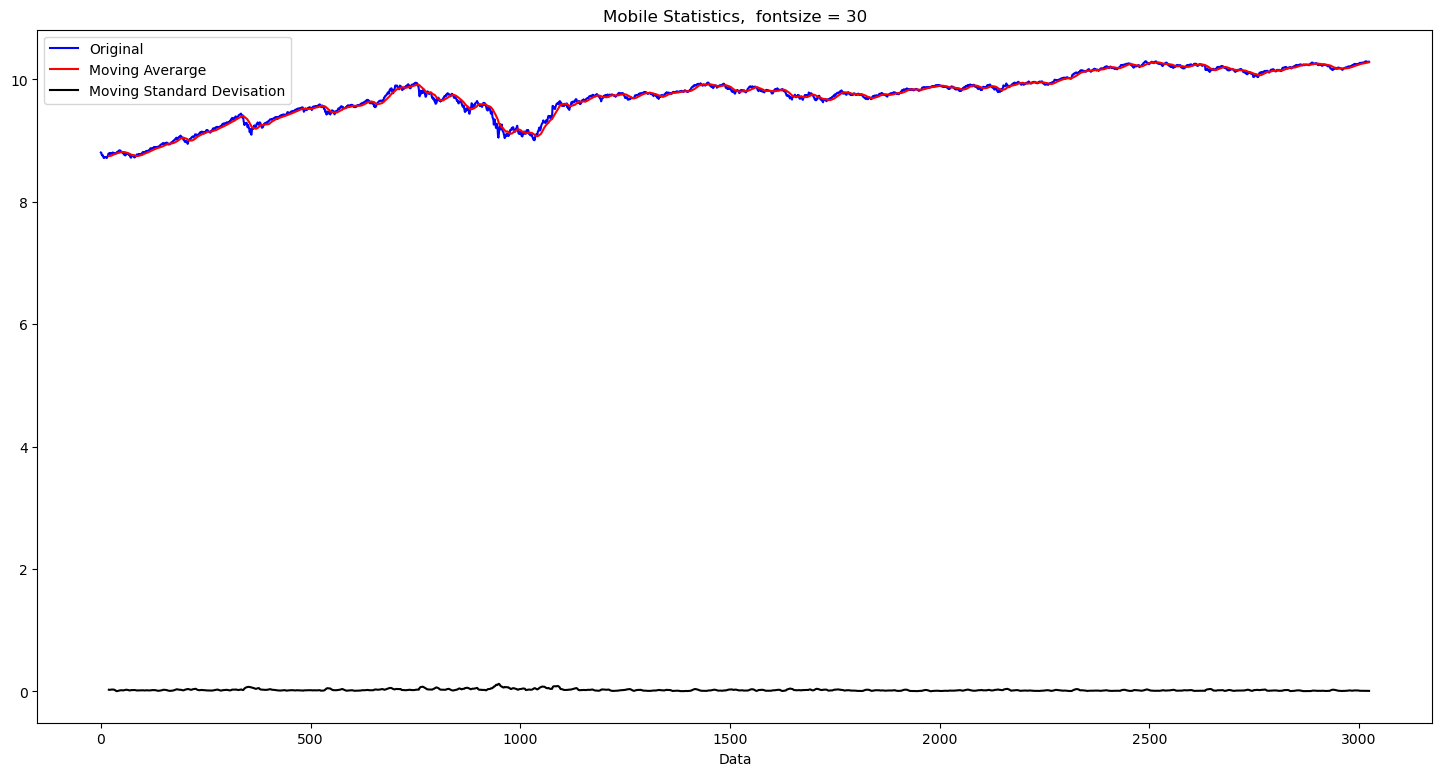

Dickey Fuller Test Results:
ADF Test Statistic : -2.0545802810776697
Valor-p : 0.26316567390878753
Number of Lags : 4
Number dof Observation : 2995
Weak evidence against null hypothesis. Time series is not stationary.


In [44]:
# Aplica a função
test_stationarity(data_train_log)

- Series not yet stationary. Let's look at it from another angle.
- Calculates the difference between log and media_movel

In [45]:
# Calcula a diferença entre log e media_movel
data_train_log_diff = data_train_log - moving_average_log
data_train_log_diff.dropna(inplace = True)

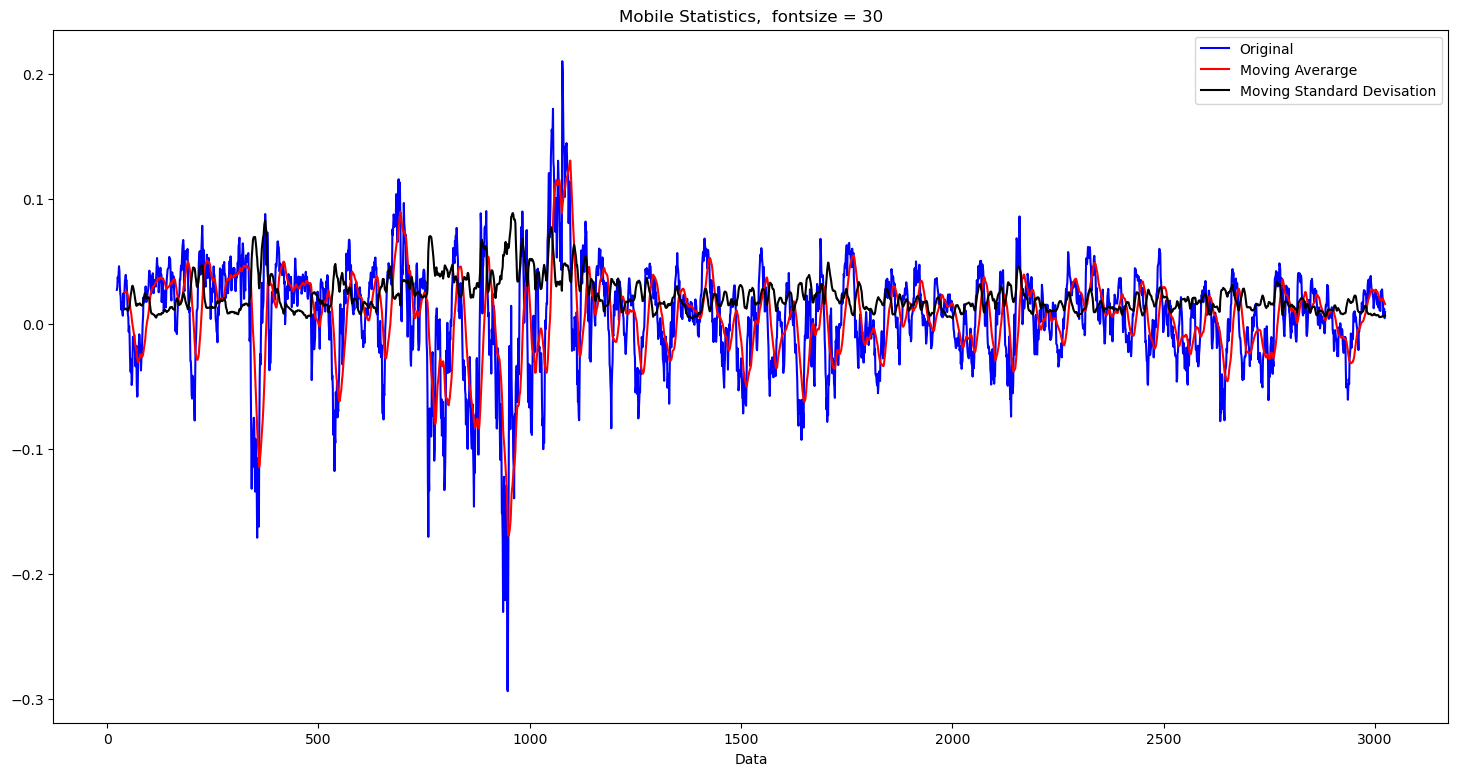

Dickey Fuller Test Results:
ADF Test Statistic : -8.109803873988955
Valor-p : 1.2345888654260006e-12
Number of Lags : 22
Number dof Observation : 2954
Strong evidence to reject the null hypothesis (H0). Data is stationary.


In [46]:
# Aplcia a função
test_stationarity(data_train_log_diff)

- After applying the difference between log and media_movel we verify that yes, the time series is stationary. Note that the p-value = 1.2345888654259243e-12, is very small, less than 0.05, thus, there is strong evidence to reject the null hypothesis (H0 - The data are not stationary). So, when checking the stationarity of the data we have to make sure we are looking at the correct angle, applying the necessary transformations, do the log transformation and do the diff.
- If after the transformations there is no stationarity in the data, then there is no pattern in the data and this time series cannot be used to build an ML model.


- Let's create an ARIMA model.** the model will search for the best model.

In [47]:
# ARIMA("AutoRegressive Integrated Moving Average") model is fit to training data training_data_log using the auto_arima function
model = auto_arima(data_train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
#prediction
prediction = model.predict(n_periods = len(data_test_log))
# Dataframe predictions
prediction = pd.DataFrame(prediction, index = data_test_log.index, columns = ['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16732.078, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16732.810, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16750.863, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16752.608, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16731.492, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16753.137, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16758.005, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16755.666, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16753.553, Time=1.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16738.810, Time=2.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16755.762, Time=1.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16747.118, Time=5.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16756.463, Time=0.30 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 17.363 sec

C:\Users\Francisco\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [48]:
prediction.head()

,Prediction
3025,10.302176
3026,10.302661
3027,10.303146
3028,10.303630
3029,10.304115


In [49]:
prediction.shape

(655, 1)

In [50]:
prediction.isna().sum()

Prediction    26
dtype: int64

In [51]:
prediction.dropna(inplace = True)

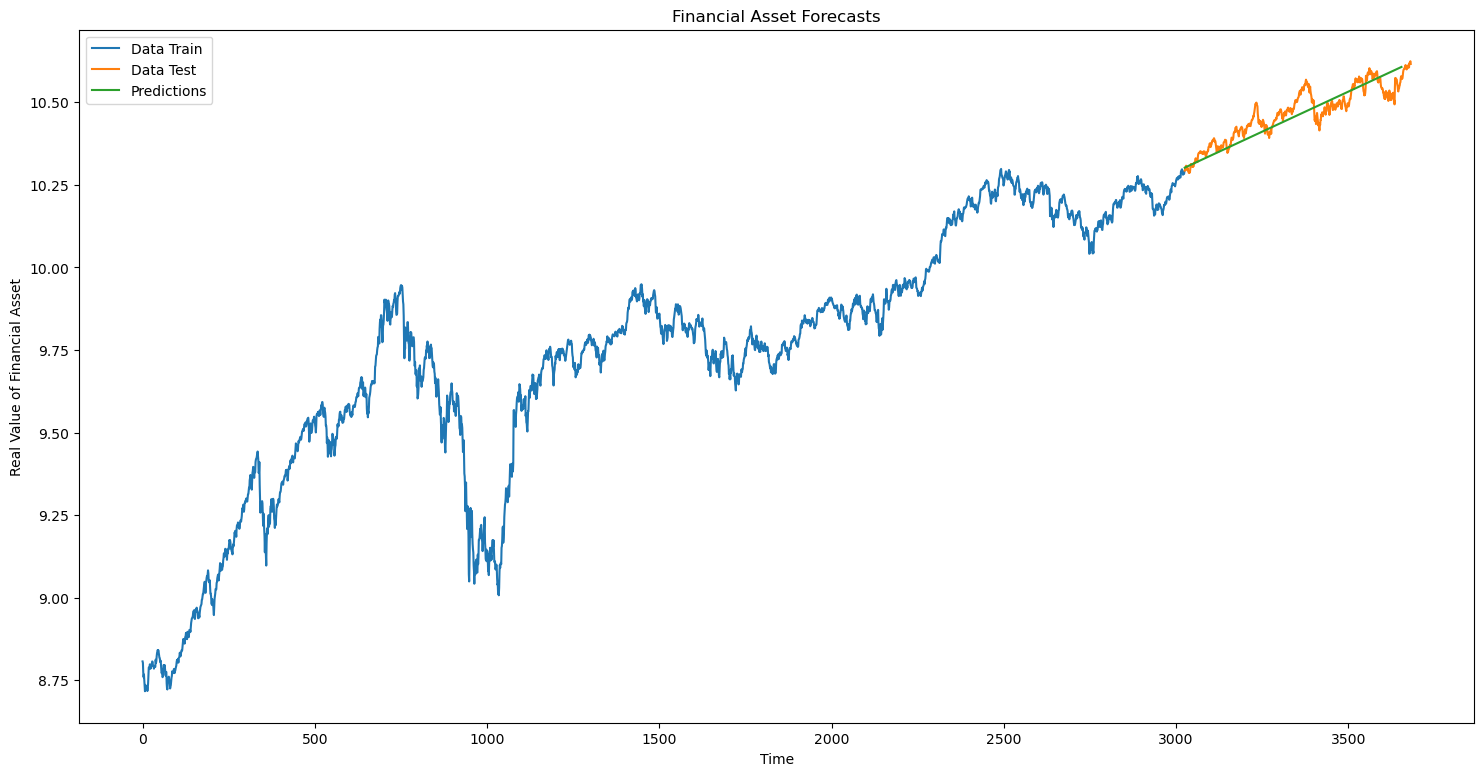

In [52]:
# Plot
plt.figure(figsize = (18,9))
plt.plot(data_train_log, label = 'Data Train')
plt.plot(data_test_log, label = 'Data Test')
plt.plot(prediction, label = 'Predictions')
plt.legend()
plt.title('Financial Asset Forecasts')
plt.xlabel('Time')
plt.ylabel('Real Value of Financial Asset')
plt.savefig('Financial Asset Forecasts')

The blue line is the training data. The orange line is the test data. The green line is the model predictions. In other words, the data follows a pattern and therefore the model can make predictions.

We calculate the model error.

In [53]:
prediction.shape

(629, 1)

In [54]:
# We need to update the data_test_log shape to calculate the RMSE
data_test_log.shape

(655,)

In [55]:
# Assuming data_test_log is a NumPy array
data_test_log = np.array(data_test_log)  # Ensure it is a NumPy array

# Number of samples to remove
n_samples = 26

# Check if there are enough elements
if len(data_test_log) >= n_samples:
    # Generate random indices
    indices_to_remove = np.random.choice(len(data_test_log), size=n_samples, replace=False)

    # Create a boolean array where True means "keep the element"
    keep_mask = np.ones(len(data_test_log), dtype=bool)  # Initially set to keep all
    keep_mask[indices_to_remove] = False  # Set False at the indices to be removed

    # Create the new array without the 26 random values
    data_test_log = data_test_log[keep_mask]
else:
    print("Not enough data to remove 26 samples.")
    data_test_log = data_test_log.copy()  # Copy original if removal is not possible




In [56]:
data_test_log.shape

(629,)

In [57]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(data_test_log, prediction))
print("RMSE : ", rms)

RMSE :  0.03727632000835942


## Textual Analysis

- Note that so far we have based our analysis only on numerical data. But, for example, can the political context change share prices? a war? a climate catastrophe? Can these events influence the economic scenario? Yes! If we bring this information to analysis it will be much more complete. Textual analysis of the events surrounding the quotes can provide more information. This is a point chosen by the analyst. There is nothing wrong with basing the analysis solely on numerical data, but by bringing information from the context that influences the data, the model created will be much more accurate.

- There are several techniques for carrying out textual analysis, we will choose sentiment analysis.


We will apply two functions to extract a score

In [58]:
# Function to obtain subjectivity 
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#### TextBlob
Natural Language Processing (NLP) library in Python. The subjectivity of a text is a measure that indicates how subjective or objective the text is, that is, to what extent it expresses opinions, personal feelings and subjectivity as opposed to objective information and concrete facts. The higher the subjectivity value, the more subjective the text. It is used to analyze the provided text and calculate sentiment polarity (how positive or negative the text is) and text subjectivity (how subjective the text is).




In [59]:
# Function to obtain subjectivity polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [60]:
# dataframe form
df_text['Subjectivity'] = df_text["News"].apply(getSubjectivity)
df_text["Polarity"] = df_text["News"].apply(getPolarity)

In [61]:
# Visualize
df_text.head()

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485


#### SentimentIntensityAnalyzer
The `SentimentIntensityAnalyzer` class is used to perform sentiment analysis on text, that is, to determine the degree of polarity compound, positivity, negativity or neutrality of a text.
- 'Compound': general polarity of the text, that is, how positive, negative or neutral the text is in its entirety.**
- 'Negative' proportion of negative feelings in the text.**
- 'Neutral': proportion of neutral feelings in the text.**
- 'Positive': proportion of positive feelings in the text.**
  This information is useful for analyzing sentiment in texts, such as evaluating the attitude or opinion expressed in news, comments or other types of text.

In [62]:
# Creating a sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [63]:
%%time
df_text['Compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_text['News']]
df_text['Negative'] = [analyzer.polarity_scores(v)['neg'] for v in df_text['News']]
df_text['Neutral']  = [analyzer.polarity_scores(v)['neu'] for v in df_text['News']]
df_text['Positive'] = [analyzer.polarity_scores(v)['pos'] for v in df_text['News']]

Wall time: 1h 4min 16s


In [64]:
# View
df_text.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131


In [65]:
df_text.shape

(7717, 8)

### Creating datasets for training models
We will create datasets to be used in time series models and supervised models

#### Merge Numeric and Text Data

In [66]:
# Let's concatenate the dataframes by the date column
df_merge = pd.merge(df_numeric, df_text, how = 'inner', on = 'Date')

In [67]:
# View
df_merge.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0,ICAI compliments minister Partnering for futur...,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0,Arab Gaze Uniform Laws Tsunami Relief Double S...,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0,Quake Rumours Mishap reunites yr boy with f...,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0,Doon School preparing to admit girls Market M...,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0,Faultline Repair No Parade Please NRI Spirit ...,0.450775,0.061027,-0.9958,0.139,0.772,0.088


In [68]:
df_merge.shape

(3655, 14)

In [69]:
# Dataframe with the variables that will be used to train the models
df_merge1 = df_merge[['Close', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]

The choices of variables that will be used in the modeling are made by the analyst. In this case, the predictor variables will be those calculated in the sentiment analysis and the target variable will be the closing variable of the price of the financial asset. Other choices could be made.

The model created will predict the closing value of a financial asset based on sentiment analysis of economic news (Attribute Engineering Work)

In [70]:
# View
df_merge1.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,6679.200195,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,6651.009766,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,6458.839844,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,6367.390137,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,6420.459961,0.450775,0.061027,-0.9958,0.139,0.772,0.088


#### Dataframes for Time Series Model.

- Depending on the type of predictive model, we will apply different data processing techniques.
- For the time series model we will use the variable "close" as my time series and the variables 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive', as exogenous variables.

In [71]:
# We place the variable that is the time series in another dataframe
df_time_series = df_merge1['Close']

In [72]:
# Exogenous variables
exog_data = df_merge1[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
exog_data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,0.450775,0.061027,-0.9958,0.139,0.772,0.088
...,...,...,...,...,...,...
3650,0.367645,0.051117,-0.9998,0.138,0.780,0.081
3651,0.384087,0.049062,-0.9999,0.163,0.750,0.087
3652,0.404191,0.051030,-0.9999,0.160,0.749,0.091
3653,0.397646,0.065572,-0.9998,0.121,0.812,0.068


In [73]:
# Training variables
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

In [74]:
# Test Variables
final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]

#### Dataframes for the supervised models.

In [75]:
# Prepare X (intput variable)
X = df_merge1.drop('Close', axis = 1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,0.450775,0.061027,-0.9958,0.139,0.772,0.088
...,...,...,...,...,...,...
3650,0.367645,0.051117,-0.9998,0.138,0.780,0.081
3651,0.384087,0.049062,-0.9999,0.163,0.750,0.087
3652,0.404191,0.051030,-0.9999,0.160,0.749,0.091
3653,0.397646,0.065572,-0.9998,0.121,0.812,0.068


In [76]:
#Prepare Y (output variable)
Y = df_merge1['Close']
Y

0        6679.200195
1        6651.009766
2        6458.839844
3        6367.390137
4        6420.459961
            ...     
3650    40889.230469
3651    40821.300781
3652    41020.609375
3653    41130.171875
3654    40793.808594
Name: Close, Length: 3655, dtype: float64

In [77]:
# Division into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Modeling Time Series Model - SARIMAX
The SARIMAX model is an extension of ARIMA, which adds the ability to include seasonal terms and exogenous variables (external factors that can also affect the dependent variable)

#### First Model SARIMAX

In [78]:
# Time series model
model_v1 = SARIMAX(final_train_data, exog = exog_train_data, order = (1, 1, 1), seasonal_order = (0, 0, 0, 0))
# Model training
result = model_v1.fit()
# Summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3000
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -20600.706
Date:                Sun, 14 Apr 2024   AIC                          41219.412
Time:                        16:49:48   BIC                          41273.467
Sample:                             0   HQIC                         41238.856
                               - 3000                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Subjectivity    58.7319    116.479      0.504      0.614    -169.563     287.026
Polarity        16.7239    113.690      0.147      0.883    -206.103     239.551
Compound        -1.1748     10.515     -0.112      0.911     -21.784      19.434
Negative      4488.6999   6090.091      0.737      0.461   -7447.659    1.64e+04
Neutral       4776.0785   6090.484      0.784      0.433   -7161.051    1.67e+04
Positive      4810.4273   6096.900      0.789      0.430   -7139.278    1.68e+04
ar.L1           -0.1794      0.159     -1.126      0.260      -0.492       0.133
ma.L1            0.2639      0.156      1.687      0.092      -0.043       0.571
sigma2        5.427e+04    790.817     68.624      0.000    5.27e+04    5.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2734.59
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**The forecast variable will contain forecasts for the next 10 days based on the SARIMAX model adjusted to the training data and using the exogenous variables provided. These predictions can be used to estimate the future behavior of the time series based on the model.**
- Using exogenous variables is common in time series models when future values depend not only on past values of the series itself, but also on other information. However, for truly future (out-of-sample) variations, we need to have these exogenous variables available for future periods. This data comes from proprietary specification, assumptions, or may be values known in advance (such as data from known events or product launches).

In [79]:
# Let's make the forecast for the next 10 days
forecast = result.forecast(10, exog = exog_test_data[:10])
forecast

3000    29419.319496
3001    29409.123651
3002    29422.798997
3003    29415.243607
3004    29410.694100
3005    29416.493963
3006    29419.034333
3007    29415.076287
3008    29408.560308
3009    29414.526787
Name: predicted_mean, dtype: float64

The forecast variable will contain forecasts for the next 10 days based on the SARIMAX model adjusted to the training data and using the exogenous variables provided. These predictions can be used to estimate the future behavior of the time series based on the model.

Important Notes:
- The use of exogenous variables is not mandatory. We use them to give the model more precision. We could create the model with or without the variables and check the best result;
- We could use one, two, three exogenous variables, there is no obligation. Use and see the results.
- We can have more than one target variable in a time series. In this case, the analysis would be called multitime series;
- It makes no sense to place exogenous (external) variables as target variables. What we want to predict is the price of the financial asset, these variables that have already been extracted are a way to support the forecast of the financial asset;

#### Second Model SARIMAX -trained with standardized data

In [80]:
from sklearn.preprocessing import StandardScaler

# Assuming data_series is your time series and exog_data are your exogenous variables
scaler_series = StandardScaler()
scaler_exog = StandardScaler()

# Fit-transform for training
data_series_scaled = scaler_series.fit_transform(np.array(final_train_data).reshape(-1,1))
exog_data_scaled = scaler_exog.fit_transform(exog_train_data)

# Transform for test data (using the same scale parameters)
data_series_test_scaled = scaler_series.transform(np.array(final_test_data).reshape(-1,1))
exog_data_test_scaled = scaler_exog.transform(exog_test_data)


In [81]:
model_vs = SARIMAX(data_series_scaled, exog = exog_data_scaled, order = (1, 1, 1), seasonal_order = (0, 0, 0, 0))
# Model training
result_vs = model_vs.fit()
#Summary
result_vs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3000
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5568.042
Date:                Sun, 14 Apr 2024   AIC                         -11118.084
Time:                        16:49:51   BIC                         -11064.030
Sample:                             0   HQIC                        -11098.641
                               - 3000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.001      0.631      0.528      -0.001       0.001
x2             0.0001      0.001      0.206      0.837      -0.001       0.001
x3         -8.062e-05      0.001     -0.128      0.898      -0.001       0.001
x4             0.0172      0.023      0.737      0.461      -0.029       0.063
x5             0.0225      0.029      0.783      0.434      -0.034       0.079
x6             0.0130      0.017      0.783      0.434      -0.020       0.045
ar.L1         -0.1800      0.161     -1.115      0.265      -0.496       0.136
ma.L1          0.2633      0.159      1.660      0.097      -0.048       0.574
sigma2         0.0014   2.08e-05     68.725      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2733.29
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
forecast_vs = result_vs.forecast(10, exog = exog_data_test_scaled[:10])
forecast_vs_original = scaler_series.inverse_transform(forecast_vs.reshape(-1,1))
print("Forecasts on the original scale:", forecast_vs_original)

Forecasts on the original scale: [[29418.83759671]
 [29409.01024669]
 [29422.5410863 ]
 [29415.41428634]
 [29410.42826396]
 [29416.45428589]
 [29419.24646956]
 [29414.62988119]
 [29408.62355129]
 [29413.75093482]]


#### Third Model SARIMAX - with AR parameter change

In [83]:
model_vl = SARIMAX(data_series_scaled, exog = exog_data_scaled, order = (2, 1, 1), seasonal_order = (0, 0, 0, 0))
# Treinamento do modelo
result_vl = model_vl.fit()
#Summary
result_vl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3000
Model:               SARIMAX(2, 1, 1)   Log Likelihood                5569.716
Date:                Sun, 14 Apr 2024   AIC                         -11119.433
Time:                        16:50:03   BIC                         -11059.373
Sample:                             0   HQIC                        -11097.829
                               - 3000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004      0.001      0.671      0.502      -0.001       0.001
x2             0.0001      0.001      0.221      0.825      -0.001       0.001
x3         -9.159e-05      0.001     -0.145      0.885      -0.001       0.001
x4             0.0122      0.023      0.522      0.602      -0.034       0.058
x5             0.0164      0.029      0.569      0.570      -0.040       0.073
x6             0.0095      0.017      0.570      0.569      -0.023       0.042
ar.L1          0.5961      0.232      2.565      0.010       0.141       1.051
ar.L2         -0.0769      0.019     -3.983      0.000      -0.115      -0.039
ma.L1         -0.5130      0.232     -2.214      0.027      -0.967      -0.059
sigma2         0.0014   2.08e-05     68.681      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2725.29
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
forecast_vl = result_vl.forecast(10, exog = exog_data_test_scaled[:10])
forecast_vl_original = scaler_series.inverse_transform(forecast_vl.reshape(-1,1))
print("Forecasts on the original scale:", forecast_vl_original)

Forecasts on the original scale: [[29419.73957692]
 [29410.10011523]
 [29422.13137434]
 [29414.00094183]
 [29408.29403435]
 [29414.0949514 ]
 [29416.70469974]
 [29412.0739572 ]
 [29406.16897727]
 [29410.1207219 ]]


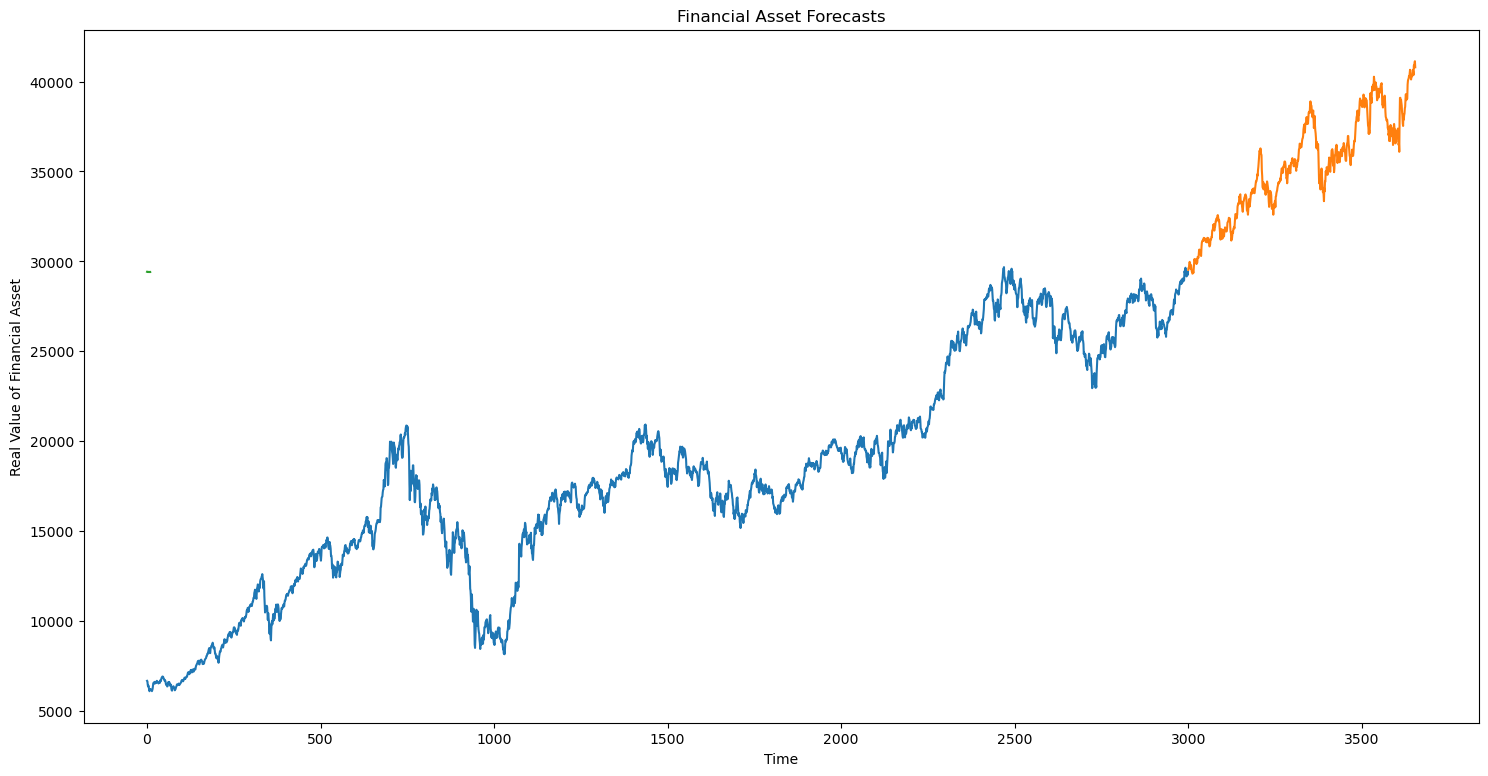

In [85]:
# Plot forecast_vl model
plt.figure(figsize = (18,9))
plt.plot(final_train_data, label = 'Data Train')
plt.plot(final_test_data, label = 'Data Test')
plt.plot(forecast_vl_original, label = 'Predictions')
plt.title('Financial Asset Forecasts')
plt.xlabel('Time')
plt.ylabel('Real Value of Financial Asset')
plt.savefig('Financial Asset Forecasts')

### Modeling with Supervised Models
Let's standardize the data and then train the models.

In [86]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit-transform para os dados de treinamento
x_train_sc = scaler_x.fit_transform(x_train)
y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1,1))

# Transform para os dados de teste (usando os mesmos parâmetros de escala)
x_test_sc = scaler_x.transform(x_test)
y_test_sc = scaler_y.transform(y_test.values.reshape(-1,1))

In [87]:
x_train_sc.shape

(2924, 6)

In [88]:
x_test_sc.shape

(731, 6)

In [89]:
x_train_sc[:10]

array([[ 2.88008076e-01,  6.49199434e-02, -2.06812189e-01,
         1.92116569e+00, -1.84184056e+00,  4.22429674e-01],
       [ 2.84029934e-01, -2.66516446e-02, -2.06812189e-01,
         1.94859621e-01, -5.52379446e-01,  6.63358990e-01],
       [-1.57976121e+00, -9.57451795e-01, -2.06812189e-01,
        -8.67482575e-01,  1.27435713e+00, -9.62913889e-01],
       [ 2.00316498e-01, -1.14277229e-01, -2.04770196e-01,
        -2.15114606e+00,  2.52799988e+00, -1.32430786e+00],
       [-1.82527438e+00,  9.38211832e-01, -1.65097201e-01,
        -2.63805290e+00,  3.20854880e+00, -1.86639882e+00],
       [-1.50670538e+00, -6.50063998e-01, -2.06812189e-01,
        -1.14990186e-01,  9.23511109e-02,  8.03372375e-04],
       [ 7.71035510e-01, -2.44426620e-01, -2.06520475e-01,
        -3.36311477e-01,  7.37081668e-01, -7.82216903e-01],
       [-8.76733539e-01,  3.41714040e-01, -2.06812189e-01,
        -7.07259282e-02, -1.22559075e-01,  3.62197346e-01],
       [ 1.09645237e+00, -1.81235301e-01, -2.068

In [90]:
y_train_sc[:10]

array([[-1.40707726],
       [ 1.54059494],
       [ 0.9114863 ],
       [ 0.65883876],
       [-0.13250274],
       [ 0.61022398],
       [-0.42856451],
       [-0.15122134],
       [-0.50436663],
       [-0.47590105]])

In [91]:
y_train_sc.shape

(2924, 1)

#### RandomForestRegressor Model

In [92]:
# Create Model
model_v2 = RandomForestRegressor()
# Training
model_v2.fit(x_train_sc, y_train_sc)
# Predictions
pred_v2 = model_v2.predict(x_test_sc)

print('Root Mean Squared Error: ', sqrt(mean_squared_error(pred_v2, y_test_sc)))

Root Mean Squared Error:  0.7077432124328797


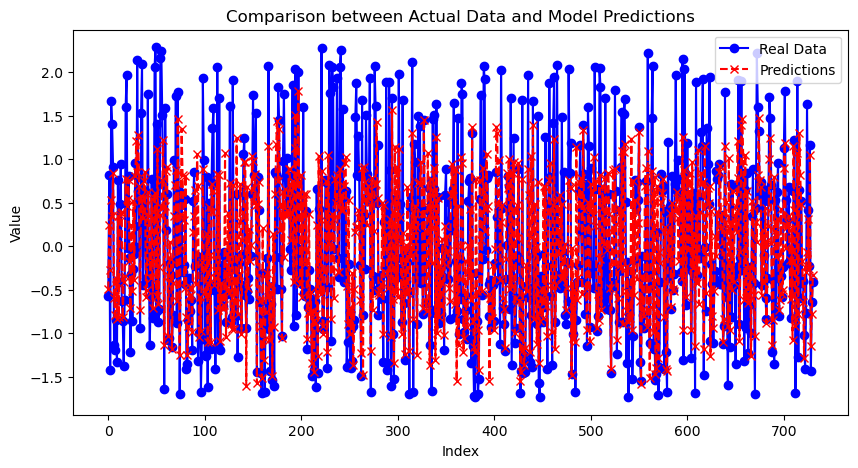

In [93]:
plt.figure(figsize=(10, 5)) # Define the size of the figure
plt.plot(y_test_sc, label='Real Data', color='blue', marker='o')  
plt.plot(pred_v2, label='Predictions', color='red', linestyle='--', marker='x') 

# Adding title and labels
plt.title('Comparison between Actual Data and Model Predictions')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding subtitle
plt.legend()
plt.savefig("Comparison between Actual Data and Model Predictions")

In [94]:
new_data = x_test[:10]
new_data_sc = scaler_x.transform(new_data)
future_predictions_sc = model_v2.predict(new_data_sc)
future_predictions = scaler_y.inverse_transform(future_predictions_sc.reshape(-1,1))

print("Forecasts for the next 10 days on the original scale:", future_predictions.flatten())

Forecasts for the next 10 days on the original scale: [16849.18343754 23219.95705091 18783.44948263 25717.74062497
 24129.48959972 28376.49164079 16014.9690333  14323.89969244
 17937.48895986 13885.27907234]


#### LGBMRegressor Model

In [95]:
# Create
model_v3 = lightgbm.LGBMRegressor()

In [96]:
# Treinamento
model_v3.fit(x_train_sc, y_train_sc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 2924, number of used features: 6
[LightGBM] [Info] Start training from score -0.000000


LGBMRegressor()

In [97]:
# Previsões
pred_v3 = model_v3.predict(x_test_sc)

In [98]:
print('Root Mean Squared Error: ', sqrt(mean_squared_error(pred_v3, y_test_sc)))

Root Mean Squared Error:  0.7009360932081602


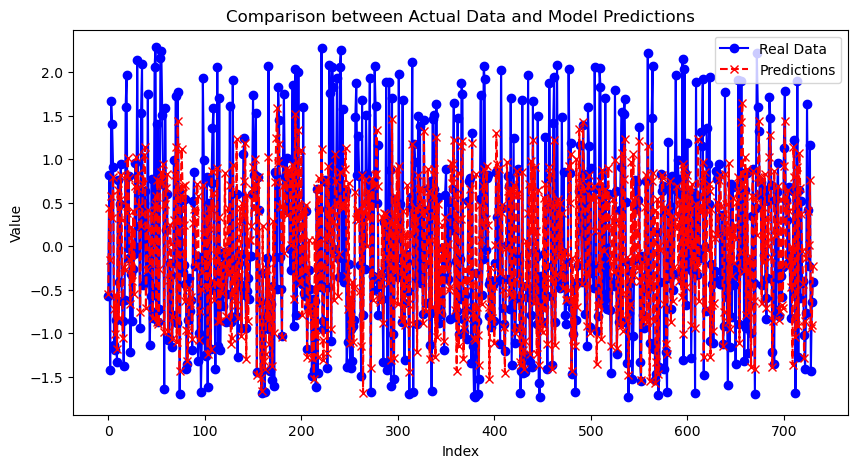

In [99]:
plt.figure(figsize=(10, 5)) # Define the size of the figure
plt.plot(y_test_sc, label='Real Data', color='blue', marker='o')  
plt.plot(pred_v3, label='Predictions', color='red', linestyle='--', marker='x') 

# Adding title and labels
plt.title('Comparison between Actual Data and Model Predictions')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding subtitle
plt.legend()
plt.savefig("Comparison between Actual Data and Model Predictions")

In [100]:
new_data = x_test[:10]
new_data_sc = scaler_x.transform(new_data)
future_predictions_sc = model_v3.predict(new_data_sc)
future_predictions = scaler_y.inverse_transform(future_predictions_sc.reshape(-1,1))
print("Forecasts for the next 10 days on the original scale:", future_predictions.flatten())

Forecasts for the next 10 days on the original scale: [16364.81235344 24881.9015     19736.9440879  26079.4626355
 23962.13081685 27977.94659992 14894.478828   12375.2515848
 16270.44305423 10885.95480099]


#### XGBRegressor Model

In [101]:
# Cria o modelo
model_v4 = xgboost.XGBRegressor()

In [102]:
# Treinamento
model_v4.fit(x_train_sc, y_train_sc)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [103]:
# Previsões
pred_v4 = model_v4.predict(x_test_sc)

In [104]:
print('Root Mean Squared Error: ', sqrt(mean_squared_error(pred_v4, y_test_sc)))

Root Mean Squared Error:  0.7415799325381136


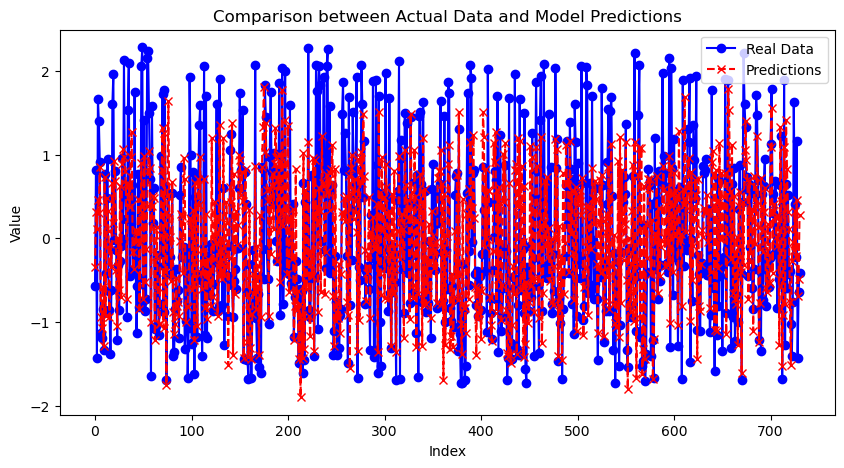

In [105]:
plt.figure(figsize=(10, 5)) # Define the size of the figure
plt.plot(y_test_sc, label='Real Data', color='blue', marker='o')  
plt.plot(pred_v4, label='Predictions', color='red', linestyle='--', marker='x') 

# Adding title and labels
plt.title('Comparison between Actual Data and Model Predictions')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding subtitle
plt.legend()
plt.savefig("Comparison between Actual Data and Model Predictions")

In [106]:
new_data = x_test[:10]
new_data_sc = scaler_x.transform(new_data)
future_predictions_sc = model_v4.predict(new_data_sc)
future_predictions = scaler_y.inverse_transform(future_predictions_sc.reshape(-1,1))
print("Forecasts for the next 10 days on the original scale:", future_predictions.flatten())

Forecasts for the next 10 days on the original scale: [18180.387 23864.7   22074.898 25051.477 23760.586 28524.623 13009.14
 11806.561 16075.778  9978.548]


### Conclusion

We built 7 versions of the predictive model using different approaches. All models have room for improvement, whether in data preprocessing or hyperparameter optimization.

One point to note about this project is that to use it in production a Data Engineer would be needed to build the entire data pipeline until feeding the trained model.

Example:

- For the SARIMAX model, imagine that we have data until June 30th and we want to predict the value of the financial asset on July 10th. We trained the model with historical data and it would be necessary to have the economic news from the 1st to the 9th of July and carry out the sentiment analysis, to then use it as exogenous variables and predict the next item in the series.

- For traditional models, we can use historical sentiment analysis data and predict the value of the financial asset regardless of the date.

Both options are almost real-time prediction and will require good Data Engineering work to build the data pipeline (sequence or flow). Nothing prevents us from using historical sentiment analysis data in both cases.